# Analyzing SLAC runs 1930-1938 with `pandas`

The input will be the `eventTree` from the `SlacAnalyzer`

---

### Import the required libraries

In [1]:
import ROOT
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
# seaborn helps makes the plots a little prettier
import seaborn
# set inline plot size
plt.rcParams['figure.figsize'] = 10, 8

Welcome to JupyROOT 6.08/02


### Open the ROOT file and grab the `eventTree`

In [2]:
slact = ROOT.TChain('slacAnalyzer/eventTree')
for run_num in range(1930, 1939):
    slact.Add('../rootOutputs/gm2slac_run0{}.root'.format(run_num))

# we are only going to use the CrystalHits
slact.SetBranchStatus("*",0)
for used_branch in ['EventNum', 'IslandNum', 'XtalNum', 'Energy', 'Time']:
    slact.SetBranchStatus('XtalHit_' + used_branch)

slact.GetEntries()

25498L

### Build a pandas dataframe out of CrystalHits
**To make things simple, we'll start with one row per CrystalHit. After this, we won't need ROOT anymore**

In [3]:
framevals = []
for i, entry in enumerate(slact):
    # keep event number incrementing across runs
    # without my having to add a run number column right now
    event_num = [i+1]*len(entry.XtalHit_EventNum)
    framevals.extend(vals for vals in zip(
        event_num, entry.XtalHit_IslandNum, entry.XtalHit_XtalNum,
        entry.XtalHit_Energy, entry.XtalHit_Time))

xtal_df = pd.DataFrame(framevals, 
                       columns=['event num', 'island num', 'xtal num', 'energy', 'time'])
xtal_df.head()

,event num,island num,xtal num,energy,time
0,1,2,0,2329.079552,0.0
1,1,2,1,1874.311430,0.0
2,1,2,2,1202.029586,0.0
3,1,2,3,2100.972561,0.0
4,1,2,4,1421.524618,0.0


**What we really need is one island per row so we can do clustering and look at correlations between crystals. This can be accomplished by "pivoting" the dataframe. The step below will sum energies and average times that have the same event number and island number, but that's ok for our tests here because pileup is not a concern in a typical SLAC run.**

In [4]:
xtal_df = xtal_df.pivot_table(index=['event num', 'island num'], columns=['xtal num'], 
                              values=['energy','time'], 
                              aggfunc={'energy' : np.sum, 'time' : np.mean})
xtal_df.head()

energy                                         \
xtal num                       0            1            2            3    
event num island num                                                       
1         0           2313.701242  1912.108032  1170.102887  2072.970301   
          1                   NaN          NaN          NaN          NaN   
          2           2329.079552  1874.311430  1202.029586  2100.972561   
          3           2221.507878  1800.483207  1164.951594  2073.201025   
          4           2339.044401  1885.115106  1173.238214  2153.315768   

                                                                          \
xtal num                       4            5            6            7    
event num island num                                                       
1         0           1528.725503  1269.971404  1323.192939  1338.101104   
          1                   NaN          NaN    13.234821          NaN   
          2           1421.524618  1304.016261  1339.837026  1397.636563   
          3           1567.671777  1255.890645  1326.379910  1402.042143   
          4           1464.718300  1298.920880  1305.223021  1317.598486   

                                                    ...                 time  \
xtal num                       8            9       ...                   44   
event num island num                                ...                        
1         0           1533.012456  1696.502981      ...         12919.231097   
          1                   NaN          NaN      ...                  NaN   
          2           1528.402974  1673.975993      ...             0.000000   
          3           1522.597807  1666.089885      ...         92928.042930   
          4           1568.284732  1693.139596      ...        172936.103599   

                                                                   \
xtal num                         45             46             47   
event num island num                                                
1         0            12919.269323   12919.256630   12919.329305   
          1                     NaN            NaN            NaN   
          2                0.000000       0.000000       0.000000   
          3            92928.071096   92928.064267   92928.104297   
          4           172936.118135  172936.133682  172936.129355   

                                                                   \
xtal num                         48             49             50   
event num island num                                                
1         0            12919.258723   12919.279334   12919.269974   
          1                     NaN            NaN            NaN   
          2                0.000000       0.000000       0.000000   
          3            92928.049931   92928.098935   92928.094708   
          4           172936.141294  172936.180591  172936.160055   

                                                                   
xtal num                         51             52             53  
event num island num                                               
1         0            12919.266220   12919.259102   12919.251700  
          1                     NaN            NaN            NaN  
          2                0.000000       0.000000       0.000000  
          3            92928.088647   92928.069875   92928.115479  
          4           172936.179294  172936.179953  172936.180279  

[5 rows x 108 columns]

In [5]:
# times are in there too
xtal_df.time.head()

xtal num                         0              1              2   \
event num island num                                                
1         0            12919.273968   12919.258992   12919.237914   
          1                     NaN            NaN            NaN   
          2                0.000000       0.000000       0.000000   
          3            92928.045067   92928.076600   92928.058223   
          4           172936.144385  172936.207725  172936.122395   

xtal num                         3              4              5   \
event num island num                                                
1         0            12919.289519   12919.253523   12919.278504   
          1                     NaN            NaN            NaN   
          2                0.000000       0.000000       0.000000   
          3            92928.090783   92928.066486   92928.086061   
          4           172936.203623  172936.164759  172936.152610   

xtal num                         6              7              8   \
event num island num                                                
1         0            12919.254874   12919.247480   12919.240390   
          1             1570.972221            NaN            NaN   
          2                0.000000       0.000000       0.000000   
          3            92928.042400   92928.095199   92928.063330   
          4           172936.113068  172936.166067  172936.120743   

xtal num                         9       ...                   44  \
event num island num                     ...                        
1         0            12919.261805      ...         12919.231097   
          1                     NaN      ...                  NaN   
          2                0.000000      ...             0.000000   
          3            92928.082546      ...         92928.042930   
          4           172936.147144      ...        172936.103599   

xtal num                         45             46             47  \
event num island num                                                
1         0            12919.269323   12919.256630   12919.329305   
          1                     NaN            NaN            NaN   
          2                0.000000       0.000000       0.000000   
          3            92928.071096   92928.064267   92928.104297   
          4           172936.118135  172936.133682  172936.129355   

xtal num                         48             49             50  \
event num island num                                                
1         0            12919.258723   12919.279334   12919.269974   
          1                     NaN            NaN            NaN   
          2                0.000000       0.000000       0.000000   
          3            92928.049931   92928.098935   92928.094708   
          4           172936.141294  172936.180591  172936.160055   

xtal num                         51             52             53  
event num island num                                               
1         0            12919.266220   12919.259102   12919.251700  
          1                     NaN            NaN            NaN  
          2                0.000000       0.000000       0.000000  
          3            92928.088647   92928.069875   92928.115479  
          4           172936.179294  172936.179953  172936.180279  

[5 rows x 54 columns]

**create columns for energy weighted time and energy sum (clustering)**

In [6]:
xtal_df[('time', 'e-weighted')] = (xtal_df.energy*xtal_df.time).sum('columns') / xtal_df.energy.sum('columns')
xtal_df[('energy', 'sum')] = xtal_df.energy.sum('columns') 
xtal_df[[('energy', 'sum'), ('time', 'e-weighted')]].head()

energy           time
xtal num                       sum     e-weighted
event num island num                             
1         0           79255.646321   12919.257494
          1            2717.374604    1571.608235
          2           79644.789369       0.000000
          3           79480.536227   92928.080743
          4           79728.341870  172936.158288

**Split laser events from beam events using energy cut**

In [7]:
beam_mask = xtal_df[('energy', 'sum')] < 50000
beam_df = pd.DataFrame(xtal_df.loc[beam_mask])
beam_df.head()

energy                                              \
xtal num                  0   1   2   3         4          5          6   
event num island num                                                      
1         1             NaN NaN NaN NaN       NaN        NaN  13.234821   
2         2             NaN NaN NaN NaN  8.452032        NaN  19.258060   
3         2             NaN NaN NaN NaN       NaN  18.768518   7.809319   
4         2             NaN NaN NaN NaN       NaN        NaN  27.791408   
5         2             NaN NaN NaN NaN       NaN        NaN        NaN   

                                                   ...      time              \
xtal num                      7          8   9     ...        46  47  48  49   
event num island num                               ...                         
1         1                 NaN        NaN NaN     ...       NaN NaN NaN NaN   
2         2           58.626702  40.434956 NaN     ...       NaN NaN NaN NaN   
3         2           23.431652  22.251673 NaN     ...       NaN NaN NaN NaN   
4         2           36.391063  71.463356 NaN     ...       NaN NaN NaN NaN   
5         2                 NaN        NaN NaN     ...       NaN NaN NaN NaN   

                                                                 energy  
xtal num              50           51  52  53   e-weighted          sum  
event num island num                                                     
1         1          NaN          NaN NaN NaN  1571.608235  2717.374604  
2         2          NaN  1579.316048 NaN NaN  1579.516482  8108.398502  
3         2          NaN  1568.622589 NaN NaN  1569.111760  4996.946992  
4         2          NaN          NaN NaN NaN  1579.990999  8772.522485  
5         2          NaN          NaN NaN NaN  1591.682020  2707.161922  

[5 rows x 110 columns]

In [8]:
laser_df = xtal_df.loc[~beam_mask]
laser_df.head()

energy                                         \
xtal num                        0            1            2            3   
event num island num                                                       
1         0           2313.701242  1912.108032  1170.102887  2072.970301   
          2           2329.079552  1874.311430  1202.029586  2100.972561   
          3           2221.507878  1800.483207  1164.951594  2073.201025   
          4           2339.044401  1885.115106  1173.238214  2153.315768   
          5           2260.577427  1808.491887  1182.203888  2240.162461   

                                                                          \
xtal num                        4            5            6            7   
event num island num                                                       
1         0           1528.725503  1269.971404  1323.192939  1338.101104   
          2           1421.524618  1304.016261  1339.837026  1397.636563   
          3           1567.671777  1255.890645  1326.379910  1402.042143   
          4           1464.718300  1298.920880  1305.223021  1317.598486   
          5           1539.366397  1272.989760  1336.362488  1407.963501   

                                                    ...                time  \
xtal num                        8            9      ...                  46   
event num island num                                ...                       
1         0           1533.012456  1696.502981      ...        12919.256630   
          2           1528.402974  1673.975993      ...            0.000000   
          3           1522.597807  1666.089885      ...        92928.064267   
          4           1568.284732  1693.139596      ...       172936.133682   
          5           1613.028315  1661.886105      ...       252945.112106   

                                                                   \
xtal num                         47             48             49   
event num island num                                                
1         0            12919.329305   12919.258723   12919.279334   
          2                0.000000       0.000000       0.000000   
          3            92928.104297   92928.049931   92928.098935   
          4           172936.129355  172936.141294  172936.180591   
          5           252945.142688  252945.070621  252945.136509   

                                                                   \
xtal num                         50             51             52   
event num island num                                                
1         0            12919.269974   12919.266220   12919.259102   
          2                0.000000       0.000000       0.000000   
          3            92928.094708   92928.088647   92928.069875   
          4           172936.160055  172936.179294  172936.179953   
          5           252945.153839  252945.153058  252945.100246   

                                                          energy  
xtal num                         53     e-weighted           sum  
event num island num                                              
1         0            12919.251700   12919.257494  79255.646321  
          2                0.000000       0.000000  79644.789369  
          3            92928.115479   92928.080743  79480.536227  
          4           172936.180279  172936.158288  79728.341870  
          5           252945.112064  252945.125200  79544.364910  

[5 rows x 110 columns]

**We'll also want a frame with only the single electron beam events.**

In [9]:
single_mask = (beam_df[('energy', 'sum')] < 3500) & (beam_df[('energy', 'sum')] > 2000) 
# explicitly copy single electron df, as we will use this from here on out
single_df = pd.DataFrame(beam_df.loc[single_mask])
single_df.head()                                                             

energy                                                    \
xtal num                  0   1   2   3   4   5          6        7         8   
event num island num                                                            
1         1             NaN NaN NaN NaN NaN NaN  13.234821      NaN       NaN   
5         2             NaN NaN NaN NaN NaN NaN        NaN      NaN       NaN   
7         1             NaN NaN NaN NaN NaN NaN        NaN      NaN       NaN   
16        1             NaN NaN NaN NaN NaN NaN        NaN  8.26387       NaN   
23        2             NaN NaN NaN NaN NaN NaN        NaN      NaN  9.043073   

                             ...      time                                     \
xtal num               9     ...        46  47  48  49  50  51         52  53   
event num island num         ...                                                
1         1          NaN     ...       NaN NaN NaN NaN NaN NaN        NaN NaN   
5         2          NaN     ...       NaN NaN NaN NaN NaN NaN        NaN NaN   
7         1          NaN     ...       NaN NaN NaN NaN NaN NaN        NaN NaN   
16        1          NaN     ...       NaN NaN NaN NaN NaN NaN        NaN NaN   
23        2          NaN     ...       NaN NaN NaN NaN NaN NaN  1570.5719 NaN   

                                        energy  
xtal num               e-weighted          sum  
event num island num                            
1         1           1571.608235  2717.374604  
5         2           1591.682020  2707.161922  
7         1           1579.673073  2614.903506  
16        1           1590.629166  2607.080167  
23        2           1570.590942  2522.681780  

[5 rows x 110 columns]

## Data structures are all in place, time to make some plots!

### Start with some energy plots

Look at calibration constants between xtal 24 & 25, must be good for this analysis to work well.
Pick out rows where xtal 24 or 25 had the most energy, and set calibration correction based on that.

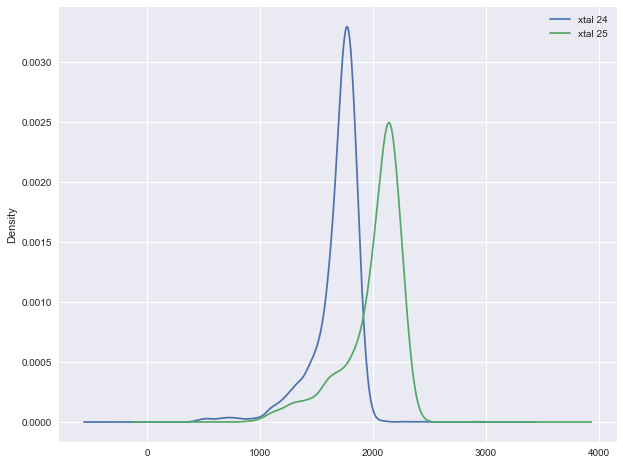

In [10]:
mask24 = (single_df.energy.loc[:,24] == single_df.energy.loc[:,range(54)].max('columns'))
mask25 = (single_df.energy.loc[:,25] == single_df.energy.loc[:,range(54)].max('columns'))
cal_df = pd.DataFrame({'xtal 24':single_df.energy.loc[mask24,24], 
                       'xtal 25':single_df.energy.loc[mask25,25]})
cal_df.plot.kde()

Doesn't look too good... let's try to fix it.

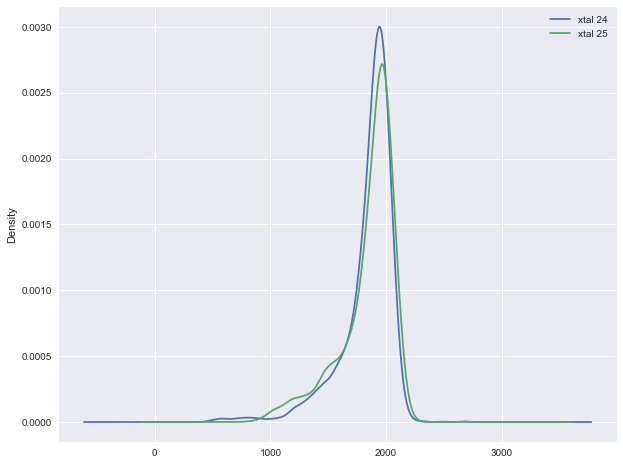

In [11]:
corrected_mean = cal_df.mean().mean()
correction_24 = corrected_mean / cal_df['xtal 24'].mean()
correction_25 = corrected_mean / cal_df['xtal 25'].mean()
cal_df *= [correction_24, correction_25]
cal_df.plot.kde()

That looks a bit better. Apply this back to the single electron dataframe and recalculate the sum column

In [12]:
single_df.loc[:, ('energy', 24)] *= correction_24
single_df.loc[:, ('energy', 25)] *= correction_25
single_df.loc[:, ('energy', 'sum')] = single_df.energy[range(54)].sum('columns')

(0, 3000)

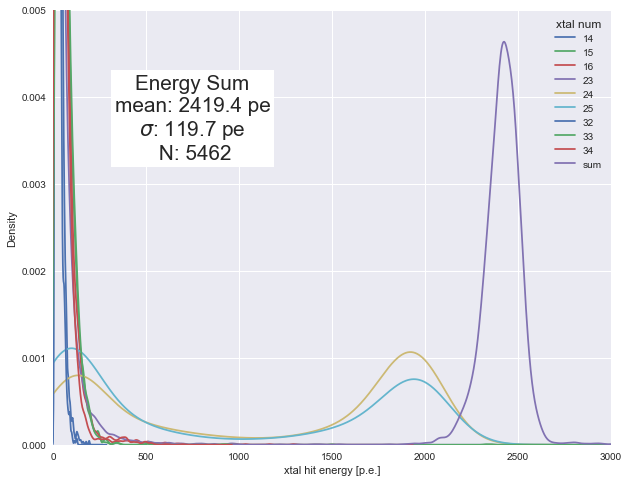

In [13]:
# plot xtal energies and their sum
center_num = 24
x_nums = [center_num + 10 - 9*(i/3) - i%3 for i in range(9)]
a = single_df.energy.loc[:,x_nums[::-1] + ['sum']].plot.kde()
stats = single_df.energy.describe()['sum']
plt.text(.25, .75, 'Energy Sum\nmean: {0:.1f} pe\n$\sigma$: {1:.1f} pe\n N: {2:.0f}'.
         format(stats['mean'], stats['std'], stats['count']), 
         horizontalalignment='center', verticalalignment='center', 
         transform=a.transAxes, size='xx-large', bbox=dict(facecolor='white', edgecolor='none'))
plt.xlabel('xtal hit energy [p.e.]')
dummy=plt.ylim(0,0.005)
plt.xlim(0,3000)

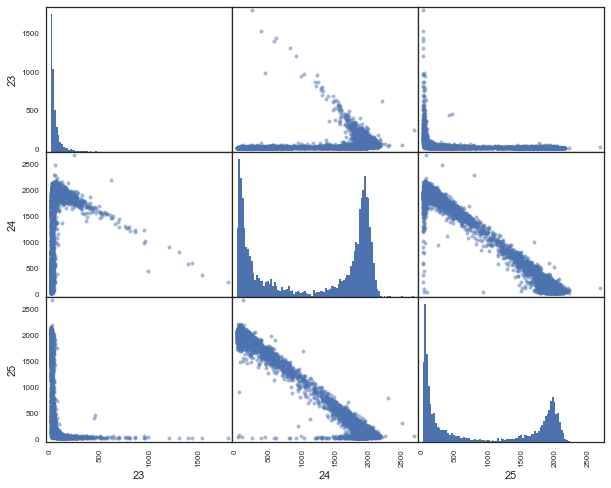

In [14]:
# crystal energy scatter matrix
seaborn.set_style('white')
from pandas.tools.plotting import scatter_matrix
smatrices=scatter_matrix(single_df.energy.iloc[:,23:26], hist_kwds={'bins': 100})

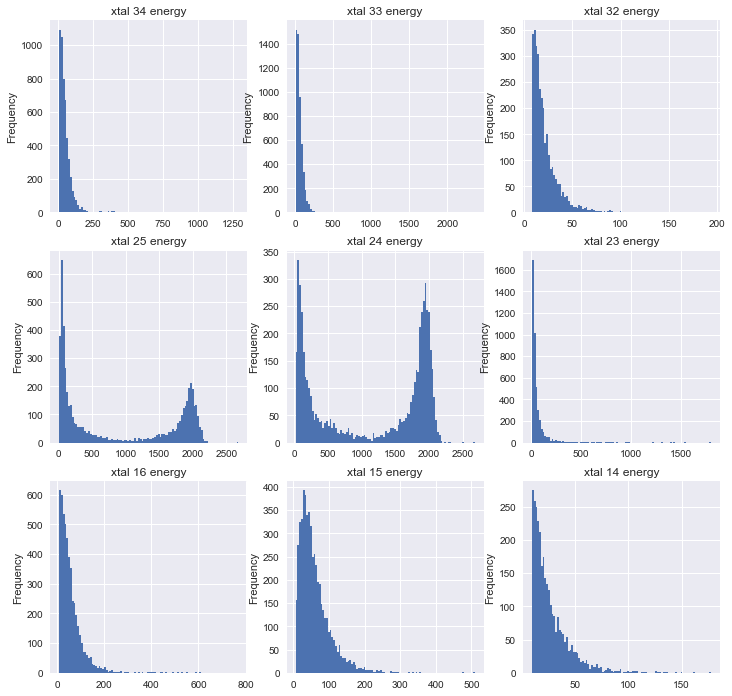

In [15]:
seaborn.set_style('darkgrid')
plt.rcParams['figure.figsize'] = 12, 12
for plotnum in range(0,9):
    plt.subplot(3,3,plotnum+1)
    x_num = x_nums[plotnum]
    (single_df.energy[x_num]).plot.hist(bins=100)
    plt.title('xtal {} energy'.format(x_num))

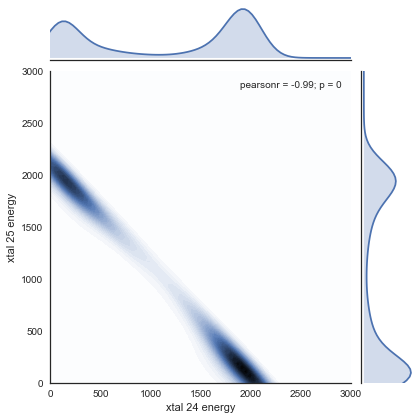

In [16]:
seaborn.set_style('white')
jp = (seaborn.jointplot(x=24, y=25, data=single_df.energy, kind='kde', n_levels=50, xlim=(0,3000), ylim=(0,3000)).
      set_axis_labels('xtal 24 energy', 'xtal 25 energy'))

## And some timing plots

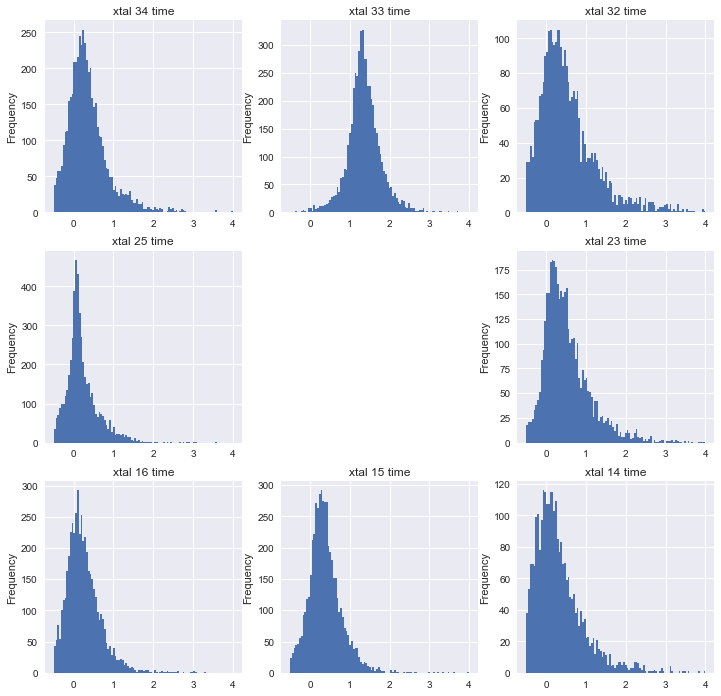

In [17]:
seaborn.set_style('darkgrid')
plt.rcParams['figure.figsize'] = 12, 12
for plotnum in range(0,9):
    if plotnum == 4:
        continue
    plt.subplot(3,3,plotnum+1)
    x_num = x_nums[plotnum]
    (single_df.time[x_num] - single_df.time[24]).plot.hist(bins=100, range=(-0.5,4))
    plt.title('xtal {} time'.format(x_num))

## For fun, lets try to implement the position reconstruction algorithm as well

In [18]:
# create a data frame with a convenient structure for doing the pos recon
hit_stack = single_df.energy[range(54)].stack() 
hit_stack = hit_stack.reset_index(level='xtal num')

hit_stack.columns = ['xtal num', 'energy']
hit_stack['island sum'] = hit_stack.energy.groupby(level=('event num', 'island num')).transform(np.sum)
hit_stack['x'] = 8.5 - hit_stack['xtal num'] % 9
hit_stack['y'] = hit_stack['xtal num'] // 9 + 0.5

hit_stack.head()

xtal num      energy  island sum    x    y
event num island num                                            
1         1                  6   13.234821  2545.57561  2.5  0.5
          1                 13   16.563590  2545.57561  4.5  1.5
          1                 14   14.327783  2545.57561  3.5  1.5
          1                 15   61.214816  2545.57561  2.5  1.5
          1                 16  106.232508  2545.57561  1.5  1.5

In [19]:
# calculate weights
w0 = 4.0
hit_stack['weight'] = np.maximum(0,w0 + np.log(hit_stack.energy / hit_stack['island sum']))
hit_stack.head()

xtal num      energy  island sum    x    y    weight
event num island num                                                      
1         1                  6   13.234821  2545.57561  2.5  0.5  0.000000
          1                 13   16.563590  2545.57561  4.5  1.5  0.000000
          1                 14   14.327783  2545.57561  3.5  1.5  0.000000
          1                 15   61.214816  2545.57561  2.5  1.5  0.272277
          1                 16  106.232508  2545.57561  1.5  1.5  0.823518

In [20]:
# calculate positions!
# add weight sum column
grouped = hit_stack.groupby(level=('event num', 'island num'), group_keys=False)
hit_stack['wsum'] = grouped.weight.transform(np.sum) 

xs = grouped.apply(lambda x: (x.weight*x.x).sum()/x.wsum.iloc[0])
ys = grouped.apply(lambda x: (x.weight*x.y).sum()/x.wsum.iloc[0])

# also use the bad "center of energy" technique to compare
xcoe = grouped.apply(lambda x: (x.energy*x.x).sum()/x['island sum'].iloc[0])
ycoe = grouped.apply(lambda x:(x.energy*x.y).sum()/x['island sum'].iloc[0])
pos_frame = pd.DataFrame({'x' : xs, 'y': ys, 'xcoe': xcoe, 'ycoe': ycoe})
pos_frame.head()

,,x,xcoe,y,ycoe
event num,island num,,,,
1,1,1.630796,1.575667,2.329823,2.440152
5,2,1.490260,1.498040,2.429272,2.478323
7,1,1.547812,1.511914,2.620464,2.548848
16,1,1.690137,1.563470,2.625168,2.537024
23,2,1.400640,1.493487,2.466760,2.496105


## Make some position reconstruction plots

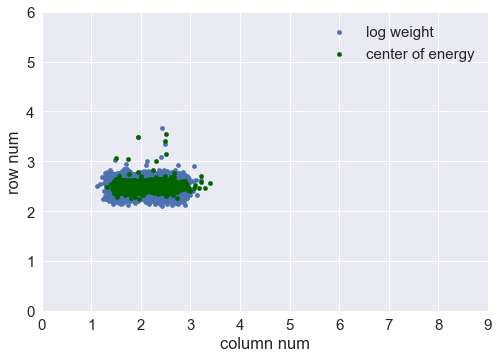

In [21]:
plt.rcParams['figure.figsize'] = 9, 6
seaborn.set(font_scale=1.5)
# plot the calculated positions and center of energy positions
ax = pos_frame.plot(kind='scatter', x='x', y='y', label='log weight')
pos_frame.plot(kind='scatter', x='xcoe', y='ycoe', label='center of energy', color='DarkGreen', ax=ax)
plt.xlim(0,9)
plt.ylim(0,6)
plt.xlabel('column num')
plt.ylabel('row num')

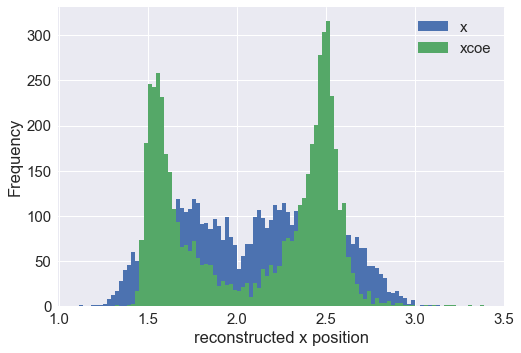

In [22]:
pos_frame[['x','xcoe']].plot.hist(bins=100)
plt.xlabel('reconstructed x position')

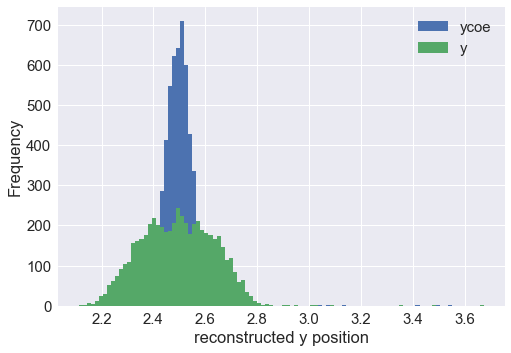

In [23]:
pos_frame[['ycoe','y']].plot.hist(bins=100)
plt.xlabel('reconstructed y position')

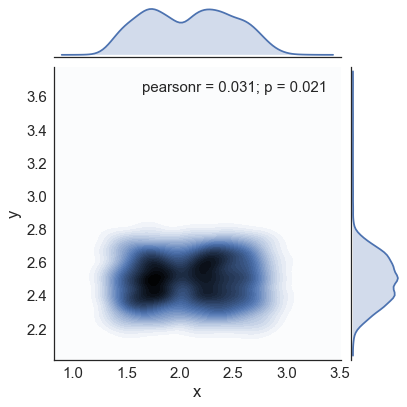

In [24]:
seaborn.set_style('white')
seaborn.jointplot(x='x', y='y', kind='kde', data=pos_frame, 
                  joint_kws={'n_levels': 40})

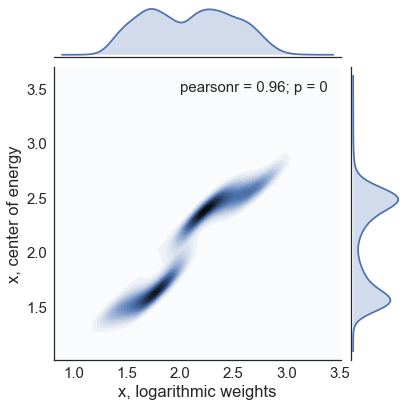

In [25]:
seaborn.set_style('white')
g=(seaborn.jointplot(x='x', y='xcoe', kind='kde', 
                    data=pos_frame, joint_kws={'n_levels': 40})
   .set_axis_labels('x, logarithmic weights', 'x, center of energy'))

**Energy vs hit position**

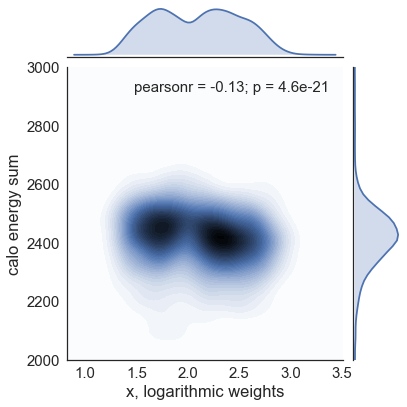

In [26]:
single_df['x'] = pos_frame.x
g=(seaborn.jointplot(x='x', y=('energy', 'sum'), kind='kde', 
                    data=single_df, joint_kws={'n_levels': 40}, ylim=(2000,3000))
   .set_axis_labels('x, logarithmic weights', 'calo energy sum'))

## Let's take a quick look at the laser energies

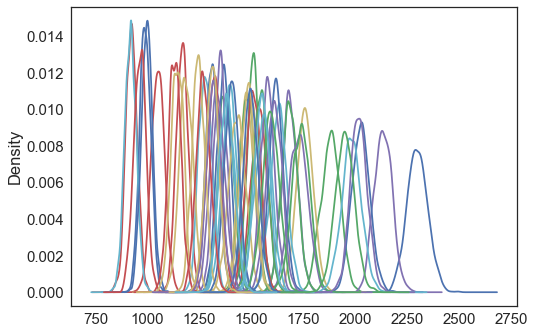

In [27]:
laser_df.energy.iloc[:2000,:54].plot.kde(legend=False)

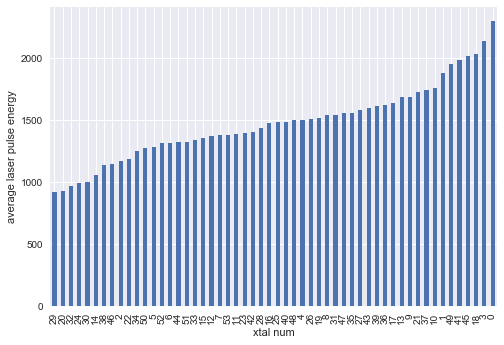

In [28]:
seaborn.set(font_scale=1)
laser_df.energy.iloc[:,:54].mean().sort_values().plot(kind='bar')
plt.ylabel('average laser pulse energy')